In [1]:
import sys,os,time,random
import numpy as np
import matplotlib
# matplotlib.use('Agg');
import matplotlib.pyplot as plt
# plt.set_cmap('jet');

import skimage
from skimage.io import imread, imsave
import pickle

from os import walk

In [5]:
# ============= FOR ICDIA =============  

patch_size = 32
framesize_w = 600
framesize_h = 800
noutputs = 1
channels = 3

In [2]:
# ============= FOR ICDIA ============= 

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath)
    print(labs.shape)
    print("This is labelpath: ", labelPath)
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print("unknown label format")
    
    binsize = [scale,scale]
    out = np.zeros(size)
    for i in range(binsize[0]):
        for j in range(binsize[1]):
            out = np.maximum(lab[i::binsize[0], j::binsize[1]], out)
        
    print(lab.sum(),out.sum())
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers,x,y,h,w):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, stride, scale):
    
    height = int((img_pad.shape[0])/1)
    width = int((img_pad.shape[1])/1)
    print("label size: ", height, width)
    labels = np.zeros((noutputs, height, width))
    for y in range(0,height):
        for x in range(0,width):
            count = getCellCountCells(markers,x*1,y*1,patch_size,patch_size)  
            for i in range(0,noutputs):
                labels[i][y][x] = count[i]

    

    count_total = getCellCountCells(markers,0,0,framesize_h+patch_size,framesize_w+patch_size)
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_x,  base_y, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    img_pad = np.pad(img[:,:],(patch_size)//2, "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:2])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    markers = np.pad(markers, patch_size, "constant", constant_values=-1)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, 1, scale)
    return img, labels, count

In [3]:
# ============= FOR ICDIA ============= 

dot_dir = "./icdia/dots/*.png"

import glob
imgs = []
for filename in glob.iglob(dot_dir):
    imgg = filename.replace(".png",".tiff")
    imgg = imgg.replace("dots","images")

    print(imgg, filename)
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

./icdia/images\220812_GFP-AHPC_A_GFAP_F10_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F10_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F1_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F1_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F2_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F2_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F4_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F4_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F5_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F5_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F7_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F7_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F8_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F8_DAPI_ND1_20x.png
./icdia/images\220812_GFP-AHPC_A_GFAP_F9_DAPI_ND1_20x.tiff ./icdia/dots\220812

In [30]:
from PIL import Image
## code to debug data generation
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 9)
imgPath,labelPath,x,y = imgs[3][0],imgs[3][1], 0, 0
#imgPath,labelPath,x,y = imgs[0][0], imgs[0][1], 100,200

print(imgPath, labelPath)

im = imread(imgPath)
img_raw_raw = Image.fromarray(im)

new_size = (int(np.array(img_raw_raw).shape[1] / 1), int(np.array(img_raw_raw).shape[0] / 1))

# Resize the image using Pillow's resize function
img_resized = img_raw_raw.resize(new_size, Image.LANCZOS) 

# Convert back to NumPy array
img_raw = np.array(img_resized)
print(np.array(img_raw_raw).shape," ->>>>", img_raw.shape)

print("img_raw",img_raw.shape)
img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, x, y, 1, 1)
print("count", count)

markers = getMarkersCells(labelPath, 1, img_raw.shape[0:2])
markers = markers[y:y+framesize_h, x:x+framesize_w]
count = getCellCountCells(markers, 0, 0, framesize_w,framesize_h)
print("count", count, 'markers max', markers.max())

print("img shape",  img.shape)
print("label shape", lab.shape)


./icdia/images\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.tiff ./icdia/dots\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.png
(600, 800)  ->>>> (600, 800)
img_raw (600, 800)
(600, 800, 3)
This is labelpath:  ./icdia/dots\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.png
464.0 464.0
label size:  632 632
count [np.int64(289)]
(600, 800, 3)
This is labelpath:  ./icdia/dots\220812_GFP-AHPC_A_GFAP_F3_DAPI_ND1_20x.png
464.0 464.0
count [np.int64(289)] markers max 1.0
img shape (600, 600)
label shape (1, 632, 632)


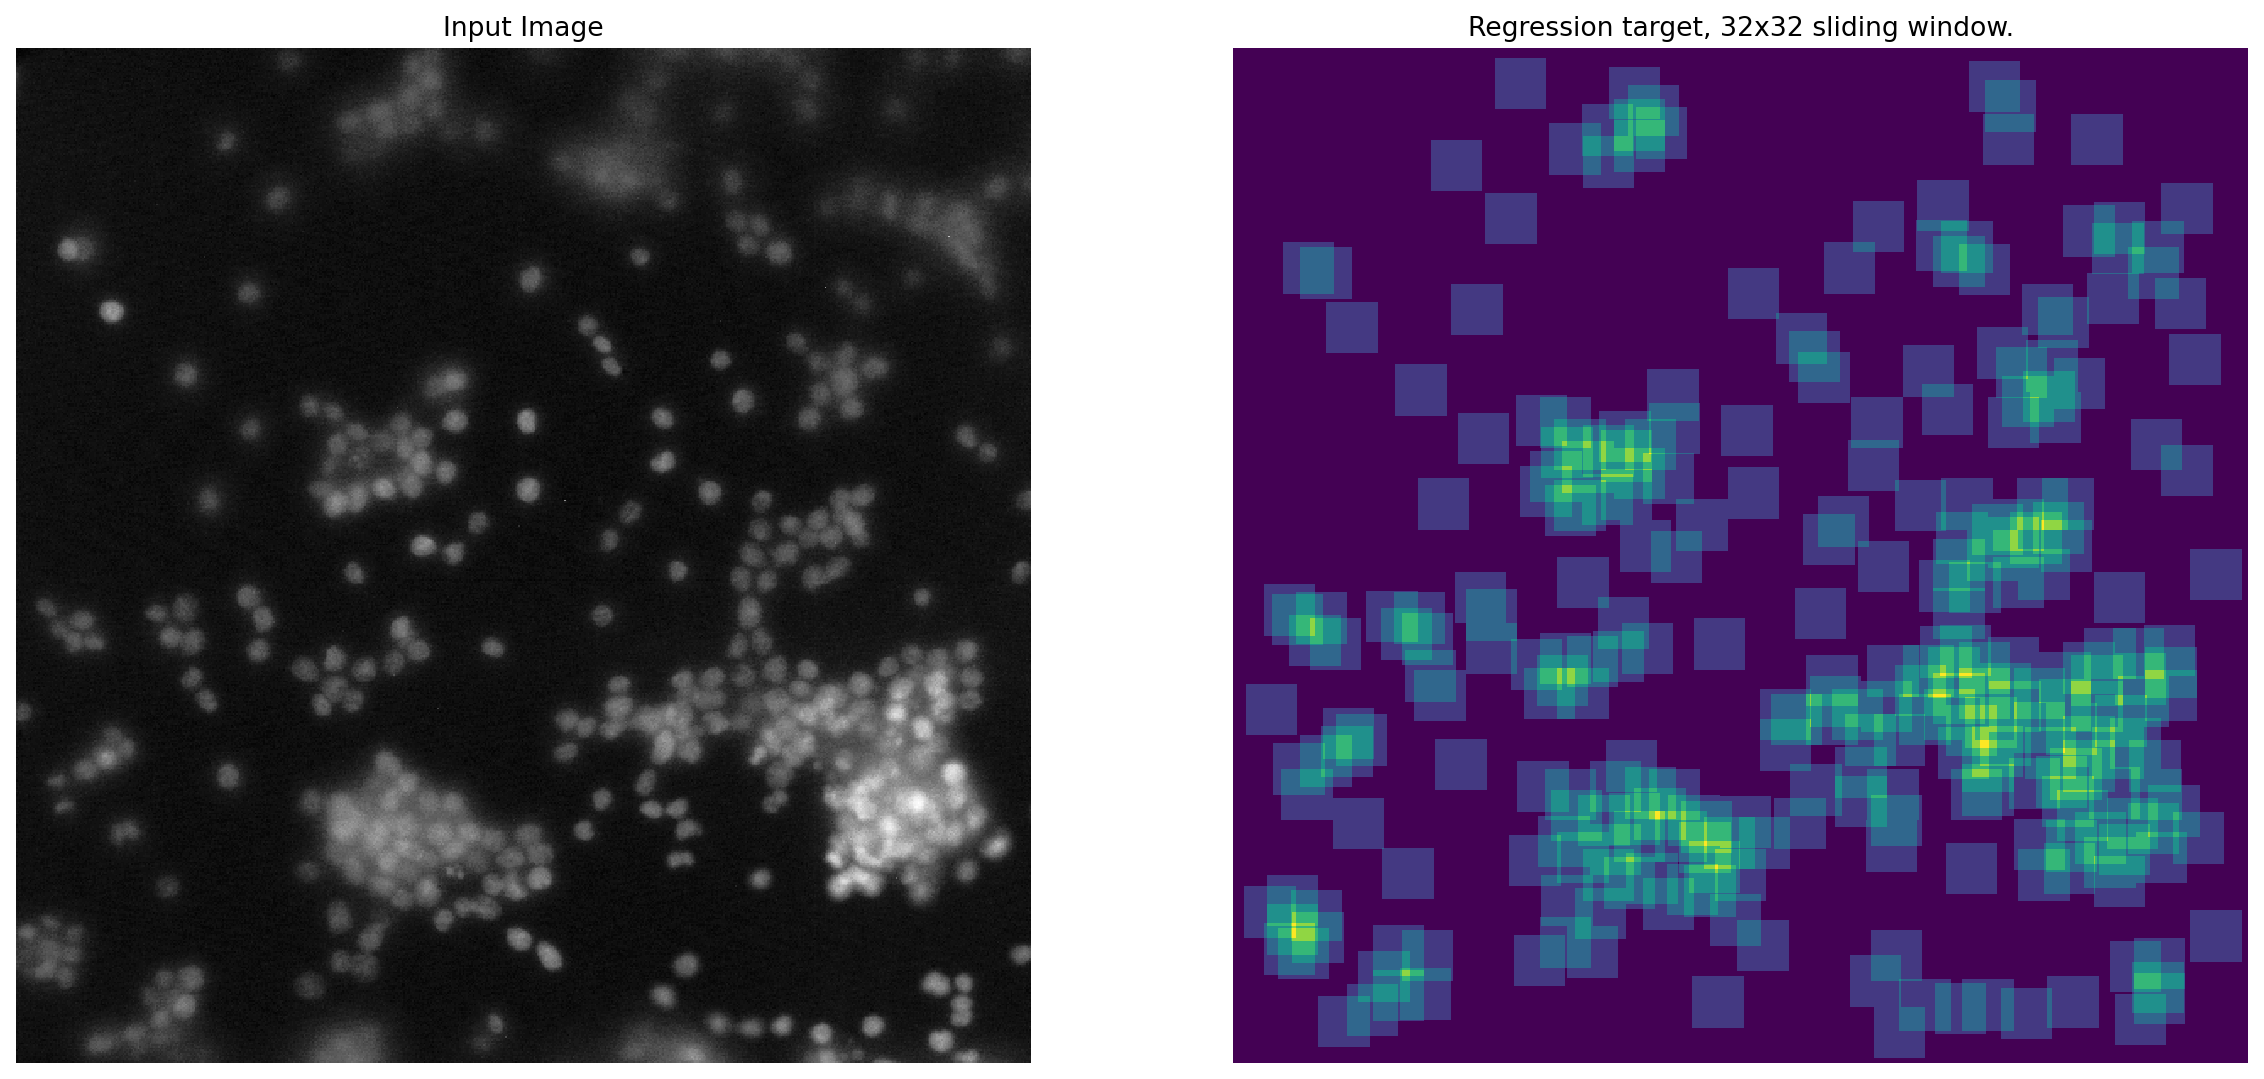

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(18, 9), dpi=160)

ax1 = axes[0]
ax1.set_title("Input Image")
ax1.imshow(img, interpolation='none', cmap='Greys_r')
ax1.axis('off') 

ax2 = axes[1]
ax2.set_title(f"Regression target, {patch_size}x{patch_size} sliding window.")
lab_concat = np.concatenate(lab, axis=1)  
ax2.imshow(lab_concat, interpolation='none', cmap='viridis')
ax2.axis('off')

plt.show()
